# Trial to Paid Classification Model

The objectvie of this machine learning project was to help a CRM company's marketing team to identify customers that are likely to convert from trial subsciption plan to paying subscription plan. To tackle the challenge, I developed a binary classification model with AWS SageMaker that predicts whether a customer converts to paying subscription plan. 

In this notebook, I am building, training, and testing a classification model built with AWS SageMaker XGBoost

Note: datasets for this project are not publicly available.

# Data Exploration

In [ ]:
# Setting up AWS S3 bucket and copying required datasets to the folder
import boto3
s3 = boto3.resource('s3')
 
user = '<username>'

base_bucket = '<basebucketname>'
project_path = '<projectpath>'
project_prefix = f'''{user}/{project_path}'''

copy_source = {
  'Bucket': base_bucket,
  'Key': f'''<copypath>/{project_path}/input/dataset.csv'''
}

if not user:
    raise NameError('Forgot to fill in user varaible')

bucket = s3.Bucket(base_bucket)

bucket.copy(copy_source, f'''{project_prefix}/input/dataset.csv''')

In [5]:
# Reading in initial dataset
import boto3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


su = pd.read_csv(f'''s3://{base_bucket}/{project_prefix}/input/dataset.csv''')

su.shape

(111861, 46)

In [6]:
su.columns

Index(['flag_converted', 'company_mrr', 'total_seat_count', 'key_company',
       'flag_promocode', 'billingdetails_entered', 'key_country',
       'day_name_of_week', 'total_users', 'industry', 'email_domain',
       'flag_clearbit_success', 'typ_event_activity_added',
       'segment_veroemail_opened', 'typ_event_person_added',
       'segment_stage_added', 'typ_flag_search', 'typ_flag_billing',
       'typ_event_pipeline_view_opened', 'segment_veroemail_unsubscribed',
       'typ_flag_pipeline_customization', 'segment_stage_updated',
       'typ_event_email_sent', 'typ_event_deal_added',
       'typ_flag_organization_details_opened', 'typ_flag_filters',
       'segment_user_logged_in', 'typ_event_deal_won',
       'typ_flag_deal_list_opened', 'typ_events_overall_activity',
       'typ_flag_calendar_sync_enabled', 'typ_flag_activity_list_opened',
       'typ_event_lead_added', 'typ_flag_lead_details_opened',
       'typ_flag_import', 'typ_flag_insights', 'typ_flag_email_sync_enabled'

In [7]:
su.head().T

,0,1,2,3,4
flag_converted,0,0,0,0,1
company_mrr,0,0,0,0,374
total_seat_count,0,0,0,1,15
key_company,7508660,7510754,7511134,7512272,7512628
flag_promocode,yes,no,yes,no,no
billingdetails_entered,no,no,no,no,yes
key_country,GB,NL,other,FR,FR
day_name_of_week,Monday,Thursday,Thursday,Sunday,Monday
total_users,1,2,7,1,5
industry,financial or credit services,health,education and training,"software, app development",it services


In [8]:
su.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111861 entries, 0 to 111860
Data columns (total 46 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   flag_converted                        111861 non-null  int64  
 1   company_mrr                           111861 non-null  int64  
 2   total_seat_count                      111861 non-null  int64  
 3   key_company                           111861 non-null  int64  
 4   flag_promocode                        111861 non-null  object 
 5   billingdetails_entered                111861 non-null  object 
 6   key_country                           111861 non-null  object 
 7   day_name_of_week                      111861 non-null  object 
 8   total_users                           111861 non-null  int64  
 9   industry                              111861 non-null  object 
 10  email_domain                          111861 non-null  object 
 11  

In [9]:
su.isnull().sum()

flag_converted                          0
company_mrr                             0
total_seat_count                        0
key_company                             0
flag_promocode                          0
billingdetails_entered                  0
key_country                             0
day_name_of_week                        0
total_users                             0
industry                                0
email_domain                            0
flag_clearbit_success                   0
typ_event_activity_added                0
segment_veroemail_opened                0
typ_event_person_added                  0
segment_stage_added                     0
typ_flag_search                         0
typ_flag_billing                        0
typ_event_pipeline_view_opened          0
segment_veroemail_unsubscribed          0
typ_flag_pipeline_customization         0
segment_stage_updated                   0
typ_event_email_sent                    0
typ_event_deal_added              

We read 111861 rows from the training dataset. The dataset has 46 columns and the column named flag_converted is used as the target column. 

In [10]:
su.head(10)

,flag_converted,company_mrr,total_seat_count,key_company,flag_promocode,billingdetails_entered,key_country,day_name_of_week,total_users,industry,...,typ_flag_email_sync_enabled,typ_flag_custom_fields,unique_users,vistis,avg_lenght_seconds,blogpageload_count,wwwpageload_count,apppageload_count,webapppageload_count,supportpageload_count
0,0,0,0,7508660,yes,no,GB,Monday,1,financial or credit services,...,0,0,0,0,0.0,0,0,0,0,0
1,0,0,0,7510754,no,no,NL,Thursday,2,health,...,0,0,1,5,529.4,0,11,3,2,0
2,0,0,0,7511134,yes,no,other,Thursday,7,education and training,...,1,0,3,17,235.1,0,12,22,34,1
3,0,0,1,7512272,no,no,FR,Sunday,1,"software, app development",...,1,1,1,5,446.8,0,12,3,5,0
4,1,374,15,7512628,no,yes,FR,Monday,5,it services,...,0,1,5,3715,1593.9,126,696,455,24478,122
5,0,0,0,7513584,yes,no,NL,Tuesday,1,other,...,0,0,1,3,1073.7,0,4,3,6,0
6,0,0,0,7515048,no,no,GB,Thursday,1,it services,...,0,0,1,44,985.1,2,43,27,226,14
7,0,0,0,7515916,no,no,GB,Saturday,1,health,...,0,0,1,4,348.3,0,9,3,1,0
8,0,0,0,7516260,no,no,other,Sunday,1,financial or credit services,...,0,0,1,7,21.9,0,1,6,4,0
9,0,0,0,7517116,no,no,other,Monday,1,it services,...,0,0,1,3,249.7,0,1,3,1,0


# Target distribution

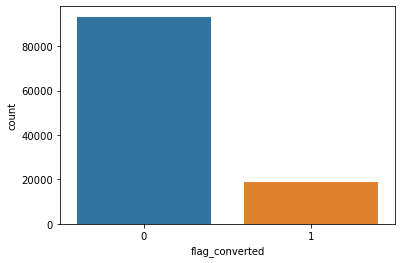

0 label:  93197 total of 83.32 %
1 label:  18664 total of 16.68 %


In [11]:
sns.countplot(x="flag_converted", data=su)
plt.show()

n_counts = su.flag_converted.value_counts()
print('0 label: ', n_counts[0], 'total of', round((n_counts[0] / len(su.index)) * 100, 2), '%')
print('1 label: ', n_counts[1], 'total of', round((n_counts[1] / len(su.index)) * 100, 2), '%')

# Feature correlation

Text(0.5, 1.0, 'Correlation Heatmap')

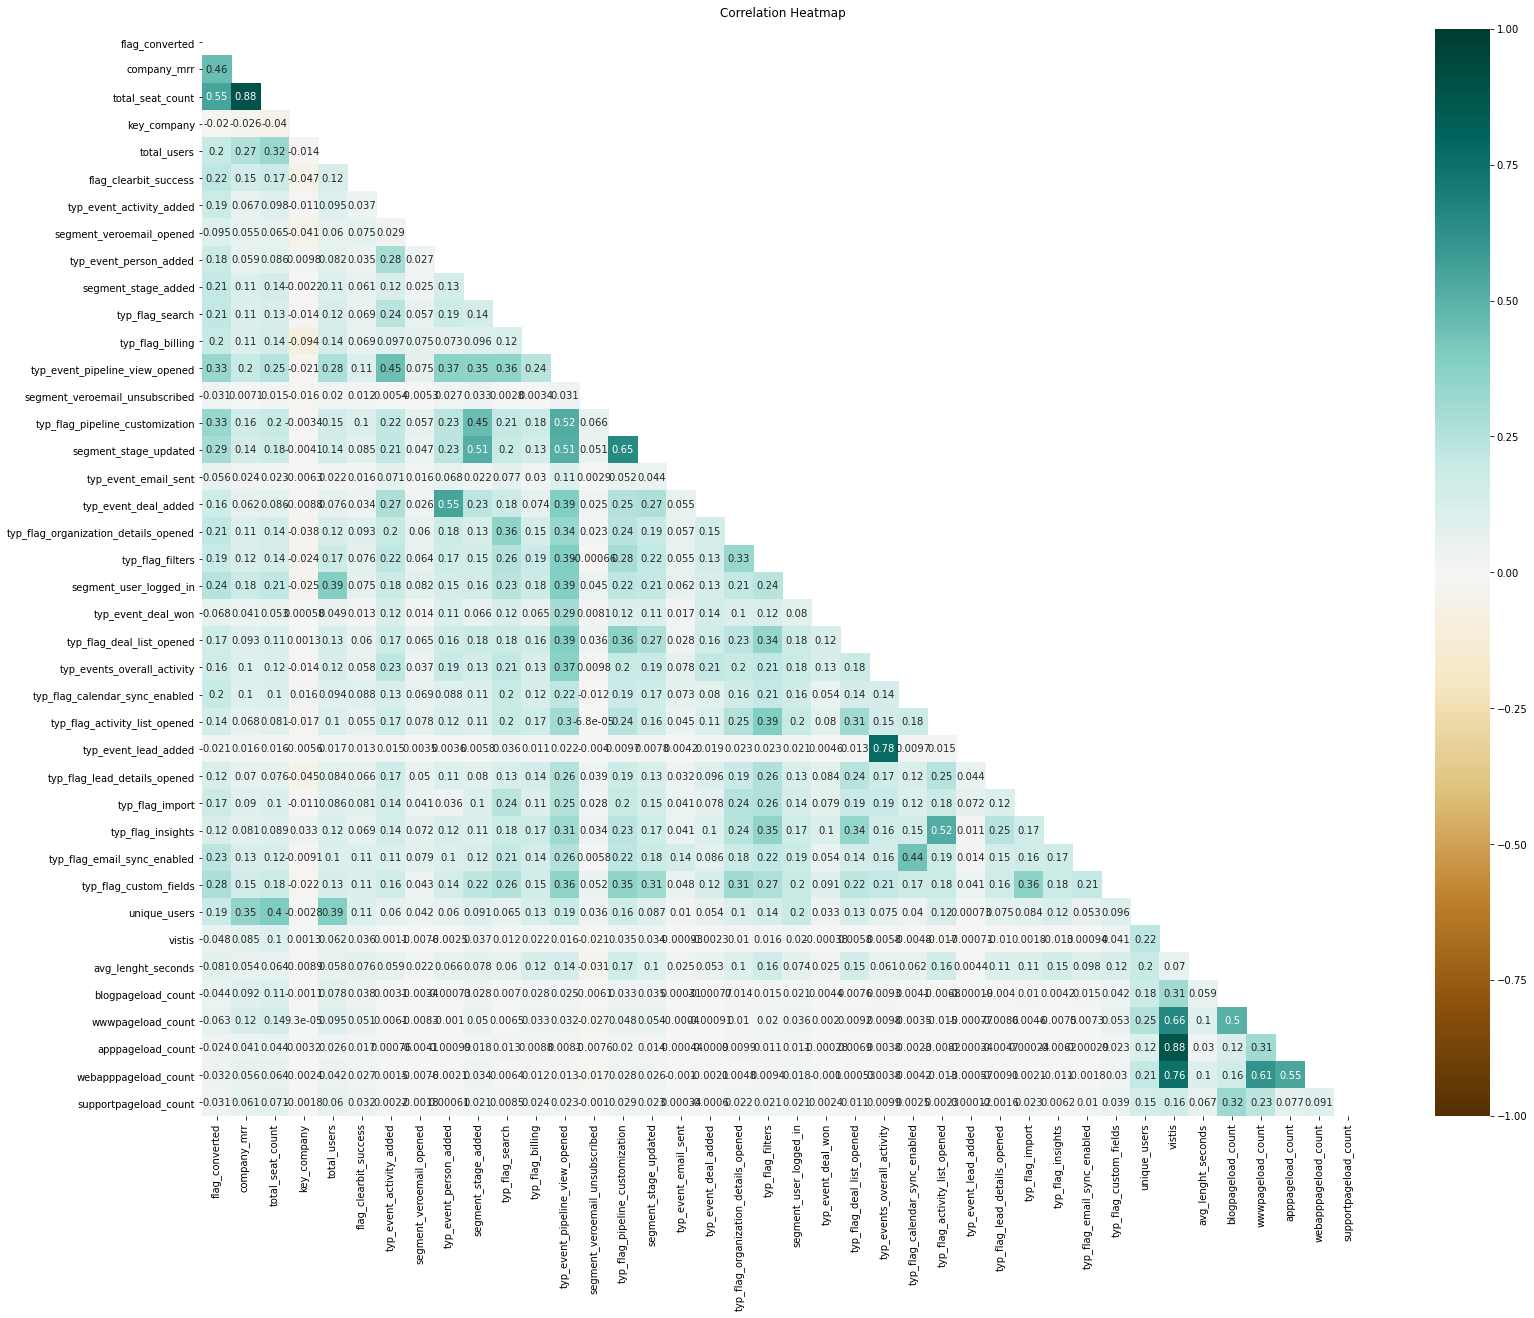

In [13]:
plt.figure(figsize=(26, 20))

# Defining the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(su.corr(), dtype=np.bool))

heatmap = sns.heatmap(su.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

In [14]:
# Defining categorical columns
categorical_columns = ['flag_promocode', 'billingdetails_entered', 'key_country', 
                       'day_name_of_week', 'industry', 'email_domain', 'flag_clearbit_success', 'typ_flag_search',
                      'typ_flag_billing', 'typ_flag_pipeline_customization', 'typ_flag_organization_details_opened',
                      'typ_flag_filters', 'typ_flag_deal_list_opened', 'typ_flag_calendar_sync_enabled', 'typ_flag_activity_list_opened',
                      'typ_flag_lead_details_opened', 'typ_flag_import', 'typ_flag_insights', 'typ_flag_email_sync_enabled', 'typ_flag_custom_fields']

In [15]:
# One Hot Encoding categorical columns
su_final = pd.get_dummies(su, columns=categorical_columns)

su_final.shape

(111861, 100)

# Splitting Data to Train, Test & Validate Sets

In [16]:
train, test, validate = np.split(su_final.sample(frac=1, random_state=42), [int(.7*len(su_final)), int(.9*len(su_final))])

In [3]:
# Why remove company_mrr, total_seat_count?
train = train.drop(['key_company', 'company_mrr', 'total_seat_count'], axis=1)

train_path=f'''s3://{base_bucket}/{project_prefix}/input/train.csv'''

train.to_csv(train_path, header=False, index=False)

print('Train data set saved to', train_path)

NameError: name 'train' is not defined

In [4]:
test = test.drop(['key_company', 'company_mrr', 'total_seat_count'], axis=1)

test_path=f'''s3://{base_bucket}/{project_prefix}/input/test.csv'''

test.to_csv(test_path, header=False, index=False)

print('Test data set saved to', test_path)

NameError: name 'test' is not defined

In [5]:
validate_path=f'''s3://{base_bucket}/{project_prefix}/input/validate.csv'''

validate.to_csv(validate_path, header=False, index=False)

print('Validation data set saved to', validate_path)

NameError: name 'base_bucket' is not defined

In [20]:
features = test.columns.to_list()
features

['flag_converted',
 'total_users',
 'typ_event_activity_added',
 'segment_veroemail_opened',
 'typ_event_person_added',
 'segment_stage_added',
 'typ_event_pipeline_view_opened',
 'segment_veroemail_unsubscribed',
 'segment_stage_updated',
 'typ_event_email_sent',
 'typ_event_deal_added',
 'segment_user_logged_in',
 'typ_event_deal_won',
 'typ_events_overall_activity',
 'typ_event_lead_added',
 'unique_users',
 'vistis',
 'avg_lenght_seconds',
 'blogpageload_count',
 'wwwpageload_count',
 'apppageload_count',
 'webapppageload_count',
 'supportpageload_count',
 'flag_promocode_no',
 'flag_promocode_yes',
 'billingdetails_entered_no',
 'billingdetails_entered_yes',
 'key_country_AU',
 'key_country_BR',
 'key_country_CA',
 'key_country_CL',
 'key_country_DE',
 'key_country_EE',
 'key_country_ES',
 'key_country_FR',
 'key_country_GB',
 'key_country_IN',
 'key_country_MX',
 'key_country_NL',
 'key_country_PL',
 'key_country_RU',
 'key_country_US',
 'key_country_ZA',
 'key_country_other',
 '

# Defining Base Model

In [21]:
import sagemaker
from sagemaker import image_uris
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput
from sagemaker.tuner import ContinuousParameter, IntegerParameter

In [22]:
# Initialising hyperparameters
hyperparameters = {
    'max_depth': '6',
    'num_round': '80',
    'objective': 'binary:logistic',
    'eval_metric': 'auc' #'eval_metric': 'auc,aucpr,error,map,accuracy'
}

# Setting an output path where the trained model will be saved
output_path = f'''s3://{base_bucket}/{project_prefix}/output'''
region = 'eu-central-1'
content_type = 'csv'

# Defining SageMaker XGBoost model container
xgboost_container = sagemaker.image_uris.retrieve('xgboost', region, '1.2-1')

# COnstructing SageMaker estimator that calls the xgboost-container
estimator = sagemaker.estimator.Estimator(image_uri=xgboost_container, 
                                          hyperparameters=hyperparameters,
                                          role=sagemaker.get_execution_role(),
                                          instance_count=1, 
                                          instance_type='ml.m5.xlarge', 
                                          volume_size=10, # 10 GB,
                                          use_spot_instances=True,
                                          max_wait=3600, # Needed when using spot instances, timeout in seconds
                                          max_run=3600,
                                          output_path=output_path
                                         )

# Defining data type and paths to the training and validation datasets
train_input = TrainingInput(train_path, content_type=content_type)
validation_input = TrainingInput(test_path, content_type=content_type)

# Executing the XGBoost training job
estimator.fit({'train': train_input, 'validation': validation_input})

2021-06-16 08:55:20 Starting - Starting the training job...
2021-06-16 08:55:22 Starting - Launching requested ML instancesProfilerReport-1623833720: InProgress
......
2021-06-16 08:56:35 Starting - Preparing the instances for training......
2021-06-16 08:57:42 Downloading - Downloading input data
2021-06-16 08:57:42 Training - Downloading the training image...
2021-06-16 08:58:18 Training - Training image download completed. Training in progress..[2021-06-16 08:58:17.957 ip-10-0-65-29.eu-central-1.compute.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_conta

In [25]:
from pprint import pprint

pprint(vars(estimator.latest_training_job))

{'job_name': 'sagemaker-xgboost-2021-06-16-08-55-20-801',
 'sagemaker_session': <sagemaker.session.Session object at 0x7f8e68830470>}


# Model Validation

In [26]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
validate

,flag_converted,company_mrr,total_seat_count,key_company,total_users,typ_event_activity_added,segment_veroemail_opened,typ_event_person_added,segment_stage_added,typ_event_pipeline_view_opened,segment_veroemail_unsubscribed,segment_stage_updated,typ_event_email_sent,typ_event_deal_added,segment_user_logged_in,typ_event_deal_won,typ_events_overall_activity,typ_event_lead_added,unique_users,vistis,avg_lenght_seconds,blogpageload_count,wwwpageload_count,apppageload_count,webapppageload_count,supportpageload_count,flag_promocode_no,flag_promocode_yes,billingdetails_entered_no,billingdetails_entered_yes,key_country_AU,key_country_BR,key_country_CA,key_country_CL,key_country_DE,key_country_EE,key_country_ES,key_country_FR,key_country_GB,key_country_IN,key_country_MX,key_country_NL,key_country_PL,key_country_RU,key_country_US,key_country_ZA,key_country_other,day_name_of_week_Friday,day_name_of_week_Monday,day_name_of_week_Saturday,day_name_of_week_Sunday,day_name_of_week_Thursday,day_name_of_week_Tuesday,day_name_of_week_Wednesday,industry_construction,industry_consulting,"industry_creative agency (web, advertising, video)",industry_education and training,industry_financial or credit services,industry_health,industry_it services,industry_manufacturing,"industry_news, media and publications",industry_not inserted,industry_other,industry_real estate,"industry_software, app development",industry_tech startup,"industry_trade (retail, wholesale)",email_domain_disposable_domain,email_domain_private_domain,email_domain_public_email_domain,flag_clearbit_success_0,flag_clearbit_success_1,typ_flag_search_0,typ_flag_search_1,typ_flag_billing_0,typ_flag_billing_1,typ_flag_pipeline_customization_0,typ_flag_pipeline_customization_1,typ_flag_organization_details_opened_0,typ_flag_organization_details_opened_1,typ_flag_filters_0,typ_flag_filters_1,typ_flag_deal_list_opened_0,typ_flag_deal_list_opened_1,typ_flag_calendar_sync_enabled_0,typ_flag_calendar_sync_enabled_1,typ_flag_activity_list_opened_0,typ_flag_activity_list_opened_1,typ_flag_lead_details_opened_0,typ_flag_lead_details_opened_1,typ_flag_import_0,typ_flag_import_1,typ_flag_insights_0,typ_flag_insights_1,typ_flag_email_sync_enabled_0,typ_flag_email_sync_enabled_1,typ_flag_custom_fields_0,typ_flag_custom_fields_1
51720,0,0,0,7604243,1,0,0,0,0,1,1,0,0,0,1,0,4,0,1,2,682.5,0,1,3,2,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0
78322,0,0,0,7577968,1,0,7,0,0,4,1,0,0,0,1,0,9,0,1,4,137.5,0,2,4,3,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,0,1,1,0,1,0
71309,0,0,0,7640259,1,0,0,9,7,5,1,0,0,9,1,0,37,0,1,2,122.5,0,1,3,3,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0
100704,0,0,0,7539774,1,0,5,0,0,2,0,0,0,0,2,0,6,0,1,2,1157.5,0,2,3,2,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0
20707,0,0,0,7646791,1,0,0,0,0,1,1,0,0,0,1,0,7,0,1,4,472.8,0,7,9,3,4,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76820,0,0,0,7689817,1,0,1,0,0,1,1,0,0,0,1,0,5,0,1,2,104.5,0,1,3,2,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0
110268

In [6]:
# Defining transformer for predicting 
transformer = estimator.transformer(
    instance_type='ml.m5.xlarge',
    instance_count=1,
    output_path=output_path,
    accept='text/csv',
    assemble_with='Line'
)


print('Output will be save to', output_path)

NameError: name 'estimator' is not defined

In [28]:
# Predicting on validation set
transformer.transform(
    validate_path,
    content_type='text/csv',
    input_filter='$[4:]', 
    split_type='Line',
    join_source='Input',
    output_filter='$[0,1,-1]' 
)


..........................[2021-06-16:09:03:16:INFO] No GPUs detected (normal if no gpus installed)
[2021-06-16:09:03:16:INFO] No GPUs detected (normal if no gpus installed)
[2021-06-16:09:03:16:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 0;

    keepalive_timeout 3;

    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }

    location / {
      return 404 "{}";
    }

  }
}


[2021-06-16 09:03:16 +0000] [23] [INFO] Startin

# Results

In [30]:
# Reading in prediction results
output_df = pd.read_csv(f'''{output_path}/validate.csv.out''', names=['flag_converted', 'total_users', 'score'])
output_df

,flag_converted,total_users,score
0,0,0,0.018122
1,0,0,0.094496
2,0,0,0.052871
3,0,0,0.165272
4,0,0,0.033585
...,...,...,...
11182,0,0,0.019791
11183,0,0,0.044176
11184,1,0,0.674217
11185,0,0,0.065678


In [32]:
# Extracting predicted and true labels
from numpy import argmax
from sklearn import metrics

y_true = output_df.iloc[:,0]
y_score = output_df.iloc[:,2]
labels = ['flag_converted'] 

Figure(432x288)
ROC AUC:  0.88
Best Threshold: 0.162272


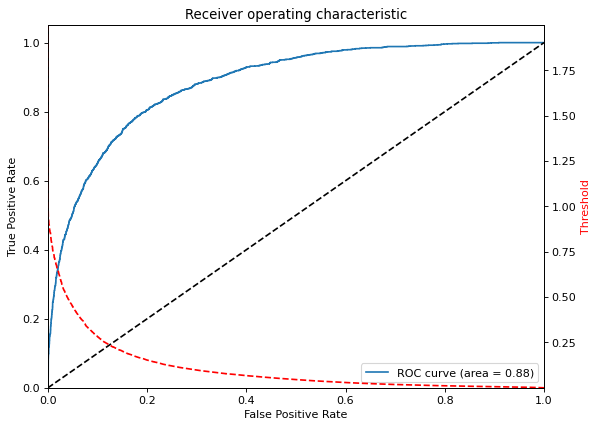

<Figure size 432x288 with 0 Axes>

In [33]:
# Producing roc auc scores
roc_auc = metrics.roc_auc_score(y_true, y_score, labels=labels)
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score) # What is fpr, tpr, thresholds? - False Positive Rate, True Positive Rate

# Getting the best threshold
J = tpr - fpr
ix = argmax(J) # argmax returns the index of highest value
best_thresh = thresholds[ix]

roc_auc = metrics.auc(fpr, tpr) # compute area under the curve

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
 
# Creating axis of thresholds
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
ax2.set_ylabel('Threshold', color='r')
ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([fpr[0],fpr[-1]])

print(plt.figure())
print ("ROC AUC: ", round(roc_auc, 2))
print('Best Threshold: %f' % (best_thresh))

In [34]:
thresold = 0.162272
thresold = 0.5

output_df['flag_predicted_convert'] = (output_df['score'] >= thresold).astype(int)
y_score = output_df.iloc[:,3]

prec, rec, fbeta_test, support = metrics.precision_recall_fscore_support(y_true, y_score, average = None)

In [35]:
print ("Average F1 Score: ", round((fbeta_test[0]+fbeta_test[1])/2, 2))
print ("Normal F1 Score: ", round(fbeta_test[0], 2))
print ("Hernia F1 Score: ", round(fbeta_test[1], 2))
print ("Average Precision Score: ", round((prec[0]+prec[1])/2, 2)) # 0.74
print ("Average Sensitivity/TPR Score: ", round((rec[0]+rec[1])/2, 2)) #0.76

Average F1 Score:  0.74
Normal F1 Score:  0.93
Hernia F1 Score:  0.55
Average Precision Score:  0.8
Average Sensitivity/TPR Score:  0.71


In [36]:
TN, FP, FN, TP = metrics.confusion_matrix(y_true, y_score).ravel()

# Sensitivity, hit rate, recall, or true positive rate 
sensitivity = float(TP)/(TP+FN)*100
# Specificity or true negative rate 
specificity = float(TN)/(TN+FP)*100
# Precision or positive predictive value 
precision = float(TP)/(TP+FP)*100
# Negative predictive value 
NPV = float(TN)/(TN+FN)*100
# Fall out or false positive rate 
FPR = float(FP)/(FP+TN)*100
# False negative rate
FNR = float(FN)/(TP+FN)*100
# False discovery rate
FDR = float(FP)/(TP+FP)*100
# Overall accuracy
ACC = float(TP+TN)/(TP+FP+FN+TN)*100

print("Sensitivity or TPR: ", round(sensitivity, 2), "%")
print("Specificity: ", round(specificity, 2), "%")
print("Precision: ", round(precision, 2), "%")
print("Negative Predictive Value: ", round(NPV, 2), "%")
print("Fall out or false positive rate: ", round(FPR, 2), "%")
print("False Negative Rate: ", round(FNR, 2), "%" )
print("False discovery rate: ", round(FDR, 2), "%" )
print("Overall accuracy: ", round(ACC, 2), "%" )

Sensitivity or TPR:  45.97 %
Specificity:  96.12 %
Precision:  68.88 %
Negative Predictive Value:  90.49 %
Fall out or false positive rate:  3.88 %
False Negative Rate:  54.03 %
False discovery rate:  31.12 %
Overall accuracy:  88.22 %
